# Проектная работа. Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

## 1. Первичный анализ данных

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
try:
    data = pd.read_csv("G:/Projects/praktikum/datasets/users_behavior.csv")
except:
    data = pd.read_csv('/datasets/users_behavior.csv')

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [3]:
data.head(5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В имеющемся датасете 3214 записей об использовании пользователями услугг тарифов.

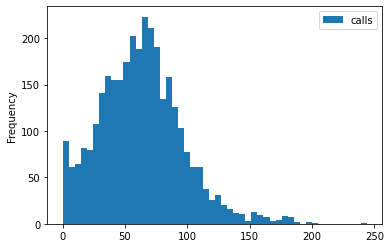

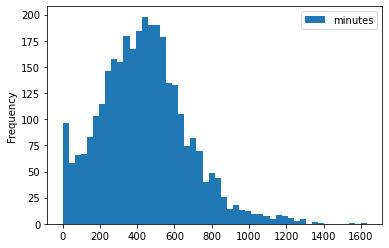

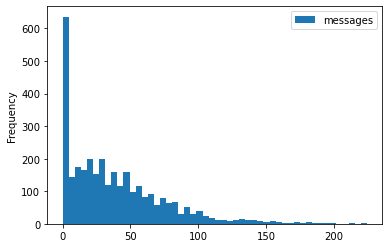

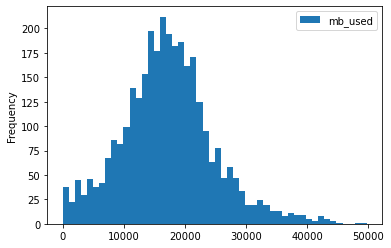

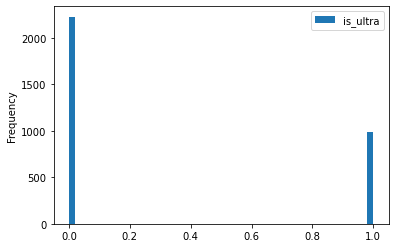

In [5]:
for each in data.columns:
    data.plot(kind='hist', y=each, bins=50)

Данные выглядят валидными. Распределения нормальные. 

Можно отметить достаточно большое количество нулевых значений по использованным услугам. Но в целом это объяснимо - кто-то может использовать тариф например в usb-модеме и тогда звонки и смс будут нулевые. Ну и с остальным так же.

## 2. Разбивка на выборки

Разделим исходные данные на обучающую, валидационную и тестовую выборки.

Обучающая - 60%
Валидационная - 20%
Тестовая - 20%

In [6]:
# сначала отрежем обучающую выборку (data_train)
data_train, data_non_train = train_test_split(data, test_size=0.4, random_state=12211)

# теперь нарежем пополам отстатки на вылидационную (data_valid) и тестовую (data_test)
data_valid, data_test = train_test_split(data_non_train, test_size=0.5, random_state=12211)

Получили 3 выборки:
* data_train - обучающая, 1928
* data_valid - валидационная, 643 записи
* data_test - тестовая, 643 записи

## 3. Исследования качества разных моделей

Подготовим данные для обучения моделей

In [7]:
# это для обучающей выборки
features = data_train.drop(['is_ultra'], axis=1)
target = data_train['is_ultra']

# это для валидационной
validation_features = data_valid.drop(['is_ultra'], axis=1)
validation_target = data_valid['is_ultra']

# это для тестовой
test_features = data_test.drop(['is_ultra'], axis=1)
test_target = data_test['is_ultra']

### 1. Решающее дерево (DecisionTreeClassifier)

Исследуем два параметра решающего дерева - глубину (max_depth) и минимальное кол-во экземпляров для образования листа дерева (min_samples_leaf).

Для этого напишем функцию, которая переберёт эти параметры, обучит модели и вернёт таблицу с результатами.

In [8]:
def tree_models_scores():
    df = pd.DataFrame(columns=['max_depth', 'min_samples_leaf', 'score'])
    for depth in range(1,20):
        for leaf in range(2,15):
            model = DecisionTreeClassifier(random_state=122111, max_depth=depth, min_samples_leaf=leaf)
            model.fit(features, target)
            
            predictions = model.predict(test_features)
            score = accuracy_score(test_target, predictions)
            scores = {'max_depth':depth, 'min_samples_leaf':leaf, 'score':score}
            df = df.append(scores, ignore_index=True)
    return df

In [9]:
# смотрим на результаты
tree_scores = tree_models_scores()
tree_scores.sort_values('score', ascending=False).head(5)

,max_depth,min_samples_leaf,score
90,7.0,14.0,0.796267
84,7.0,8.0,0.796267
83,7.0,7.0,0.796267
85,7.0,9.0,0.794712
89,7.0,13.0,0.794712


Наилучшие результаты дерево показывает при глубине 7 и 7 экземпляров для листа. 

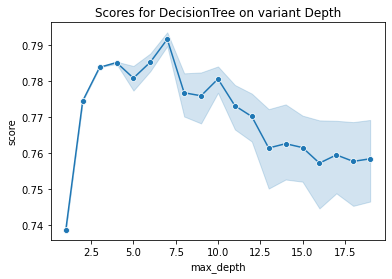

In [10]:
# взглянем на графике
ax = sns.lineplot(data=tree_scores, x='max_depth', y='score', marker='o')
ax.set_title('Scores for DecisionTree on variant Depth')
plt.show()

Действительно. После значения 7 модель переобучается и точность резко падает.

Проверим модель на валидационной выборке.

In [11]:
model = DecisionTreeClassifier(random_state=122111, max_depth=7, min_samples_leaf=7)
model.fit(features, target)
valid_predictions = model.predict(validation_features)
print('Tree classifier validation score:', accuracy_score(validation_target, valid_predictions))

Tree classifier validation score: 0.7962674961119751


#### Вывод:
В модели дерева удалось достигнуть точности 79.62%!
Неплохо. Наверное.

### 2. Случайный лес (RandomForestClassifier)

Для случайного леса проверим влияние параметра n_estimators на качество модели.

Так же напишем для этого функцию.

In [12]:
def forest_models_scores():
    df = pd.DataFrame(columns=['n_estimators', 'score'])
    for estimator in range(1,50):     
        model = RandomForestClassifier(random_state=122111, n_estimators=estimator)
        model.fit(features, target)              
        predictions = model.predict(test_features)  
        score = accuracy_score(test_target, predictions)     
        scores = {'n_estimators':estimator, 'score':score}
        df = df.append(scores, ignore_index=True)
    return df

In [13]:
# смотрим на результаты
tree_scores = forest_models_scores()
tree_scores.sort_values('score', ascending=False).head(5)

,n_estimators,score
16,17.0,0.800933
11,12.0,0.799378
15,16.0,0.799378
33,34.0,0.797823
31,32.0,0.797823


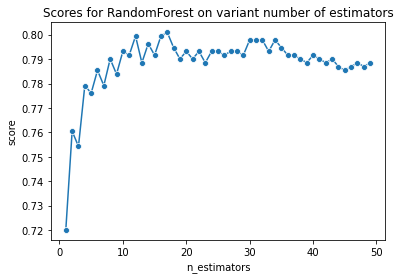

In [14]:
# взглянем на графике
ax = sns.lineplot(data=tree_scores, x='n_estimators', y='score', marker='o')
ax.set_title('Scores for RandomForest on variant number of estimators')
plt.show()

С параметром n_estimators = 17 удалось добиться наилучшего качества модели.

Проверим модель с найденными параметрами на валидационной выборке.

In [15]:
model = RandomForestClassifier(random_state=122111, n_estimators=17)
model.fit(features, target)
valid_predictions = model.predict(validation_features)
print('Random Forest Classifier validation score:', accuracy_score(validation_target, valid_predictions))

Random Forest Classifier validation score: 0.8009331259720062


#### Вывод:
В модели случайного леса удалось достигнуть точности 80%! 
Просто замечательно!

### 3. Логистическая регрессия (LogisticRegression)

Для модели логистической регрессии проверим какой скор она выдаст. 

In [16]:
# Обучаем модель
model = LogisticRegression(random_state=122111, solver='liblinear')
model.fit(features, target)

# проверим на валидационной выборке
valid_predictions = model.predict(validation_features)
print('LogisticRegression validation score:', accuracy_score(validation_target, valid_predictions))

LogisticRegression validation score: 0.7542768273716952


#### Вывод:

Модель логистической регрессии показала точность лишь 75.42%.

## 4. Выводы:

Входными данными были записи об использовании услугами мобильной связи пользователями двух тарифов Смарт и Ультра.

Целью работы были анализ точности предсказаний выбора тарифов на различных моделях и влияние параметров моделей sklearn на точность.
Для этого исходный датасет был разбит на три выборки: обучающую, тестовую и валидационную в соотношении (3-1-1).

В ходе работы были проанализированы три различные модели машинного обучения библиотеки sklearn и найдены параметры, дающие максимальные значения accuracy для наших выборок:
* Модель DecisionTreeClassifier (max_depth=7, min_samples_leaf=7). Валидационная точность: 79.62%
* Модель RandomForestClassifier (n_estimators = 17). Валидационная точность: 80.09%
* Модель LogisticRegression. Валидационная точность: 75.42%

Таким образом, в качестве наиболее точной рекомендательной модели, можно предложить модель случайного леса с указанными параметрами.